**Install libraries**

In [ ]:
!pip install datasets pandas numpy matplotlib seaborn -q krippendorff -q

print(" Installation completed! ")

 Installation completed! 


## Step 1: Setup Environment

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from collections import Counter
import krippendorff

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print(" Libraries imported! ")

 Libraries imported! 


## Step 2: Load the Dataset

**Why HateXplain?**
I chose HateXplain because:
1. It's a real, published dataset used in academic research
2. Each sample has 3 annotators - perfect for agreement analysis
3. It includes rationales (explanations) for why annotators chose each label
4. It's directly relevant to Trust & Safety work

**Why load from GitHub instead of HuggingFace?**
The HuggingFace datasets library had compatibility issues with the latest version,
so I loaded the raw JSON directly from the official repository.

**What I expect to find:**
Around 20K samples with labels: normal, offensive, or hatespeech.

In [ ]:
# Load HateXplain from GitHub
import json
import urllib.request

print("Loading HateXplain dataset from GitHub...")

url = "https://raw.githubusercontent.com/hate-alert/HateXplain/master/Data/dataset.json"

with urllib.request.urlopen(url) as response:
    raw_data = json.loads(response.read().decode())

print(f"Dataset loaded!")
print(f"Total samples: {len(raw_data):,}")
print(f"Sample IDs (first 5): {list(raw_data.keys())[:5]}")

Loading HateXplain dataset from GitHub...
Dataset loaded!
Total samples: 20,148
Sample IDs (first 5): ['1179055004553900032_twitter', '1179063826874032128_twitter', '1178793830532956161_twitter', '1179088797964763136_twitter', '1179085312976445440_twitter']


## Step 3: Understand the Data Structure

**Why explore before analyzing?**
I never jump straight into analysis. First, I need to understand:
- What fields does each sample have?
- How is the data organized?
- What do the values look like?

This prevents mistakes later. For example, if I assumed there were 2 annotators
but there are actually 3, my agreement calculations would be wrong.

**What I found:**
Each sample has:
- `post_id`: Unique identifier
- `annotators`: List of 3 annotators, each with label, annotator_id, and target
- `rationales`: Which words the annotator highlighted as problematic
- `post_tokens`: The text split into words

This structure tells me I can analyze both the labels AND the reasoning.

In [ ]:
# Explore structure of one sample
sample_id = list(raw_data.keys())[0]
sample = raw_data[sample_id]

print(f"Sample ID: {sample_id}")
print(f"\nKeys in this sample:")
for key in sample.keys():
    print(f"   - {key}")

print(f"\nFull sample content:")
print(json.dumps(sample, indent=2))

Sample ID: 1179055004553900032_twitter

Keys in this sample:
   - post_id
   - annotators
   - rationales
   - post_tokens

Full sample content:
{
  "post_id": "1179055004553900032_twitter",
  "annotators": [
    {
      "label": "normal",
      "annotator_id": 1,
      "target": [
        "None"
      ]
    },
    {
      "label": "normal",
      "annotator_id": 2,
      "target": [
        "None"
      ]
    },
    {
      "label": "normal",
      "annotator_id": 3,
      "target": [
        "None"
      ]
    }
  ],
  "rationales": [],
  "post_tokens": [
    "i",
    "dont",
    "think",
    "im",
    "getting",
    "my",
    "baby",
    "them",
    "white",
    "9",
    "he",
    "has",
    "two",
    "white",
    "j",
    "and",
    "nikes",
    "not",
    "even",
    "touched"
  ]
}


## Step 4: Label and Target Distribution

**Why check distribution first?**
Before diving into agreement analysis, I want to know the baseline:
- Are the labels balanced or skewed?
- What groups are targeted most?

This context helps interpret later findings. For example, if 90% of labels were
"normal", then high agreement might just mean everyone defaults to "normal".

**What I found:**
- normal: 40.4%
- hatespeech: 29.9%
- offensive: 29.7%

The distribution is relatively balanced, which is good. It means agreement metrics
won't be artificially inflated by one dominant class.

Top targets: African, Islam, Women, Jewish - these are groups commonly targeted
in hate speech, which validates that the dataset is realistic.

In [ ]:
# Explore unique labels and targets
all_labels = []
all_targets = []

for post_id, sample in raw_data.items():
    for annotator in sample['annotators']:
        all_labels.append(annotator['label'])
        all_targets.extend(annotator['target'])

print("Label Distribution:")
label_counts = Counter(all_labels)
for label, count in label_counts.most_common():
    pct = count / len(all_labels) * 100
    print(f"   {label}: {count:,} ({pct:.1f}%)")

print(f"\n Top 15 Target Groups:")
target_counts = Counter(all_targets)
for target, count in target_counts.most_common(15):
    print(f"   {target}: {count:,}")

Label Distribution:
   normal: 24,449 (40.4%)
   hatespeech: 18,070 (29.9%)
   offensive: 17,925 (29.7%)

 Top 15 Target Groups:
   None: 21,314
   African: 10,015
   Islam: 6,686
   Women: 6,126
   Jewish: 5,961
   Homosexual: 5,617
   Other: 4,708
   Refugee: 3,100
   Arab: 2,907
   Caucasian: 2,359
   Men: 1,758
   Asian: 1,350
   Hispanic: 1,299
   Christian: 270
   Disability: 221


## Step 5: Annotator Agreement Analysis

**Why measure agreement?**
In data labeling, "quality" often means "consistency". If annotators frequently
disagree, it suggests either:
1. The guidelines are unclear
2. The content is genuinely ambiguous
3. Some annotators need more training

**How I measured it:**
For each sample, I checked if all 3 annotators gave the same label:
- Full agreement (3/3): All same
- Partial agreement (2/3): Two same, one different  
- No agreement (1/1/1): All different

**What I found:**
- Full agreement: 48.9%
- Partial agreement: 46.6%
- No agreement: 4.6%

This is concerning. Less than half of samples have full agreement.
It suggests significant issues with either guidelines or content ambiguity.

In [ ]:
# Analyze annotator agreement per sample
agreement_data = []

for post_id, sample in raw_data.items():
    labels = [ann['label'] for ann in sample['annotators']]

    # Count unique labels
    unique_labels = len(set(labels))

    # Check if all 3 agree
    full_agreement = (unique_labels == 1)

    # Get majority label (most common)
    majority_label = Counter(labels).most_common(1)[0][0]

    # Agreement type
    if unique_labels == 1:
        agreement_type = "Full (3/3)"
    elif unique_labels == 2:
        agreement_type = "Partial (2/3)"
    else:
        agreement_type = "No agreement (1/1/1)"

    agreement_data.append({
        'post_id': post_id,
        'labels': labels,
        'unique_labels': unique_labels,
        'full_agreement': full_agreement,
        'majority_label': majority_label,
        'agreement_type': agreement_type
    })

# Convert to DataFrame
df_agreement = pd.DataFrame(agreement_data)

print("Agreement Distribution:")
print(df_agreement['agreement_type'].value_counts())
print(f"\n Agreement Rate: {df_agreement['full_agreement'].mean()*100:.1f}%")

Agreement Distribution:
agreement_type
Full (3/3)              9845
Partial (2/3)           9384
No agreement (1/1/1)     919
Name: count, dtype: int64

 Agreement Rate: 48.9%


**Visualize Agreement Distribution**

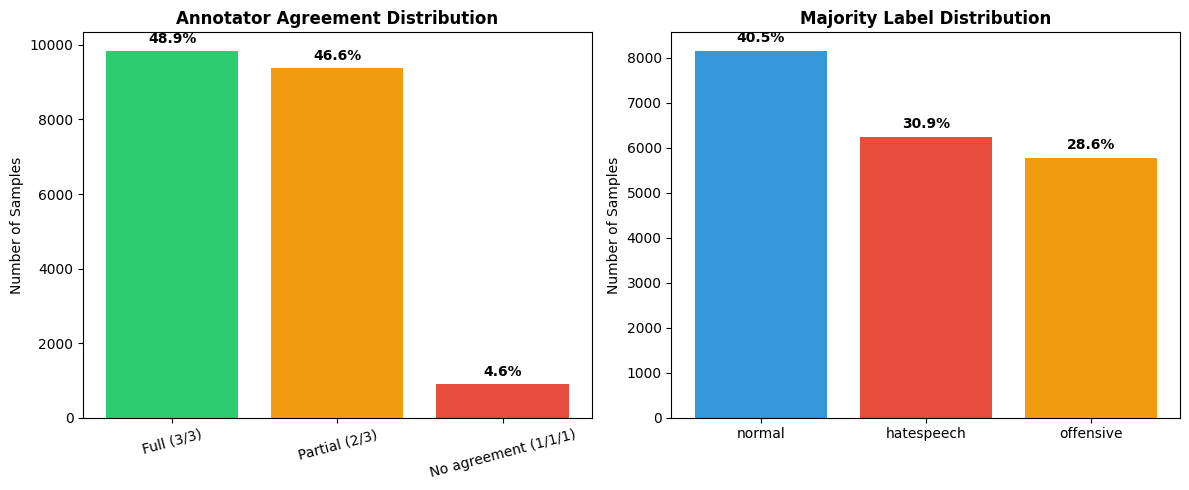

Visualization complete!


In [ ]:
# Visualize agreement distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Agreement Type Distribution
agreement_counts = df_agreement['agreement_type'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(agreement_counts.index, agreement_counts.values, color=colors)
axes[0].set_title('Annotator Agreement Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=15)

# Add percentage labels
for i, (idx, val) in enumerate(agreement_counts.items()):
    pct = val / len(df_agreement) * 100
    axes[0].text(i, val + 200, f'{pct:.1f}%', ha='center', fontweight='bold')

# Plot 2: Majority Label Distribution
majority_counts = df_agreement['majority_label'].value_counts()
colors2 = ['#3498db', '#e74c3c', '#f39c12']
axes[1].bar(majority_counts.index, majority_counts.values, color=colors2)
axes[1].set_title('Majority Label Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Samples')

# Add percentage labels
for i, (idx, val) in enumerate(majority_counts.items()):
    pct = val / len(df_agreement) * 100
    axes[1].text(i, val + 200, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization complete!")

## Step 6: Label Confusion Analysis

**Why create a confusion matrix?**
I know annotators disagree, but WHERE do they disagree? Which label pairs
cause the most confusion? This will tell me exactly what to fix in guidelines.

**What I found:**
- normal ↔ offensive: 9,095 confusions
- offensive ↔ hatespeech: 8,751 confusions
- normal ↔ hatespeech: 3,679 confusions

**Key insight:**
The "offensive" label is the problem. It confuses with BOTH other labels.
This makes sense - "offensive" is the middle ground, and its boundaries
with "normal" and "hatespeech" are unclear.

**What this means for guidelines:**
We need clearer rules for when something is offensive vs. hatespeech.
The current definition is probably too vague.

In [ ]:
# Analyze which label pairs cause disagreement
from itertools import combinations

# Only look at samples with disagreement
df_disagree = df_agreement[df_agreement['agreement_type'] != 'Full (3/3)'].copy()

# Count label pair patterns
pair_patterns = []

for _, row in df_disagree.iterrows():
    labels = sorted(row['labels'])
    pair_patterns.append(tuple(labels))

pattern_counts = Counter(pair_patterns)

print("Top 10 Disagreement Patterns:")
print("=" * 50)
print(f"{'Pattern':<40} {'Count':>8}")
print("=" * 50)

for pattern, count in pattern_counts.most_common(10):
    pct = count / len(df_disagree) * 100
    pattern_str = " vs ".join(pattern)
    print(f"{pattern_str:<40} {count:>5} ({pct:.1f}%)")

Top 10 Disagreement Patterns:
Pattern                                     Count
hatespeech vs hatespeech vs offensive     2235 (21.7%)
normal vs normal vs offensive             2050 (19.9%)
normal vs offensive vs offensive          2038 (19.8%)
hatespeech vs offensive vs offensive      1681 (16.3%)
hatespeech vs normal vs offensive          919 (8.9%)
hatespeech vs hatespeech vs normal         740 (7.2%)
hatespeech vs normal vs normal             640 (6.2%)


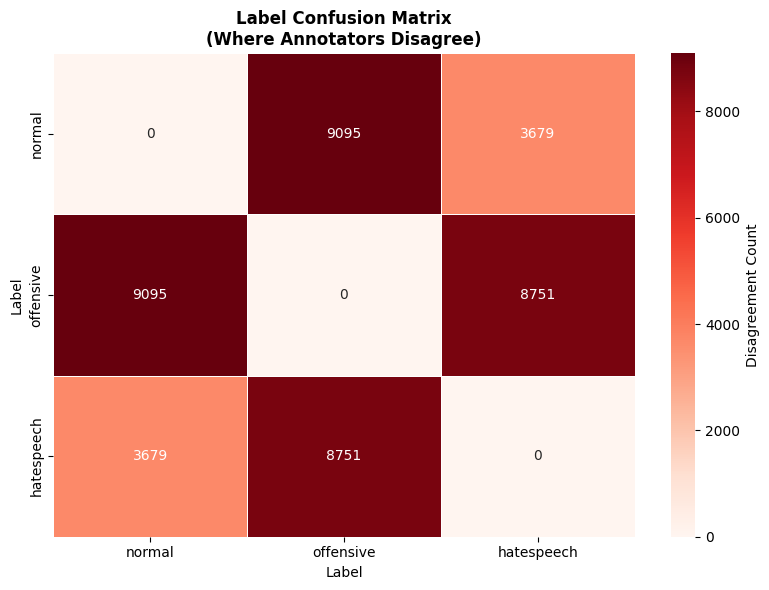

Higher numbers = More confusion between those labels


In [ ]:
# Create label confusion heatmap
labels_list = ['normal', 'offensive', 'hatespeech']

# Build confusion matrix for disagreement
confusion_matrix = pd.DataFrame(0, index=labels_list, columns=labels_list)

for _, row in df_disagree.iterrows():
    labels = row['labels']
    # Count pairs
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            l1, l2 = labels[i], labels[j]
            if l1 != l2:
                confusion_matrix.loc[l1, l2] += 1
                confusion_matrix.loc[l2, l1] += 1

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds',
            linewidths=0.5, cbar_kws={'label': 'Disagreement Count'})
plt.title('Label Confusion Matrix\n(Where Annotators Disagree)', fontsize=12, fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

print("Higher numbers = More confusion between those labels")

## Step 7: Krippendorff's Alpha Calculation

**Why use Krippendorff's Alpha instead of simple % agreement?**
Simple percentage doesn't account for agreement by chance. If I randomly guess labels, I'd get ~33% agreement just by luck (since there are 3 possible labels). Krippendorff's Alpha corrects for this chance agreement.

It's also the industry standard metric cited in academic papers and used by companies for annotation quality assessment.

**Interpretation thresholds (from Krippendorff, 2004):**
- α ≥ 0.8: Reliable - good for drawing conclusions
- α ≥ 0.667: Acceptable - use with caution  
- α < 0.667: Poor - data not reliable enough

**Build annotator-level data**

In [ ]:
# Build annotator-level data
annotator_data = []

for post_id, sample in raw_data.items():
    majority_label = df_agreement[df_agreement['post_id'] == post_id]['majority_label'].values[0]

    for ann in sample['annotators']:
        annotator_data.append({
            'post_id': post_id,
            'annotator_id': ann['annotator_id'],
            'label': ann['label'],
            'majority_label': majority_label,
            'agrees_with_majority': ann['label'] == majority_label
        })

df_annotators = pd.DataFrame(annotator_data)

print(f" Annotator data created: {len(df_annotators):,} rows")
print(f" Unique annotators: {df_annotators['annotator_id'].nunique()}")

 Annotator data created: 60,444 rows
 Unique annotators: 253


**Analyze each annotator's behavior**

In [ ]:
# Analyze each annotator's behavior
annotator_stats = df_annotators.groupby('annotator_id').agg({
    'label': 'count',
    'agrees_with_majority': 'mean'
}).rename(columns={
    'label': 'total_labels',
    'agrees_with_majority': 'agreement_rate'
})

# Add label distribution per annotator
label_dist = df_annotators.groupby(['annotator_id', 'label']).size().unstack(fill_value=0)
label_pct = label_dist.div(label_dist.sum(axis=1), axis=0) * 100

annotator_stats = annotator_stats.join(label_pct)
annotator_stats = annotator_stats.sort_values('agreement_rate', ascending=False)

print(" Annotator Statistics:")
print("=" * 70)
print(annotator_stats.round(1))

 Annotator Statistics:
              total_labels  agreement_rate  hatespeech  normal  offensive
annotator_id                                                             
26                      82             1.0        93.9     6.1        0.0
40                       5             1.0        60.0    40.0        0.0
36                      17             1.0        35.3    41.2       23.5
124                     15             1.0        53.3    46.7        0.0
117                      3             1.0        66.7     0.0       33.3
...                    ...             ...         ...     ...        ...
173                     10             0.4         0.0     0.0      100.0
166                      5             0.4        20.0    40.0       40.0
174                      3             0.3         0.0    33.3       66.7
188                      3             0.3        33.3    33.3       33.3
135                     10             0.3        30.0    10.0       60.0

[253 rows x 5 

## Step 8: Individual Annotator Behavior

**Why analyze individual annotators?**
Agreement issues could come from:
1. Unclear guidelines (affects everyone)
2. Individual annotator problems (affects specific people)

By analyzing each annotator, I can identify if certain individuals are outliers.

**How I measured bias:**
Strictness Score = % hatespeech - % normal
- Positive score = Strict (labels hatespeech more often)
- Negative score = Lenient (labels normal more often)

I set threshold at ±20 because it captures clearly skewed behavior. This threshold is somewhat arbitrary - in a real project, I'd discuss with the team to determine what level of deviation is acceptable.

**What I found:**
- 43% are Lenient
- 39% are Balanced  
- 18% are Strict

**Key insight:**
Most annotators lean lenient. This means the dataset probably UNDER-labels hate speech rather than over-labels it. For a Trust & Safety application, this is concerning - we might miss harmful content.

**Filter annotators with enough samples & visualize**

In [ ]:
# Cell 12: Analyze annotators with sufficient samples (min 100 labels)
min_samples = 100
experienced_annotators = annotator_stats[annotator_stats['total_labels'] >= min_samples].copy()

print(f" Annotators with {min_samples}+ labels: {len(experienced_annotators)}")
print(f"\n Agreement Rate Statistics:")
print(f"   Mean: {experienced_annotators['agreement_rate'].mean():.1%}")
print(f"   Min:  {experienced_annotators['agreement_rate'].min():.1%}")
print(f"   Max:  {experienced_annotators['agreement_rate'].max():.1%}")
print(f"   Std:  {experienced_annotators['agreement_rate'].std():.1%}")

 Annotators with 100+ labels: 83

 Agreement Rate Statistics:
   Mean: 81.1%
   Min:  55.6%
   Max:  98.5%
   Std:  10.2%


**Visualize annotator behavior patterns**

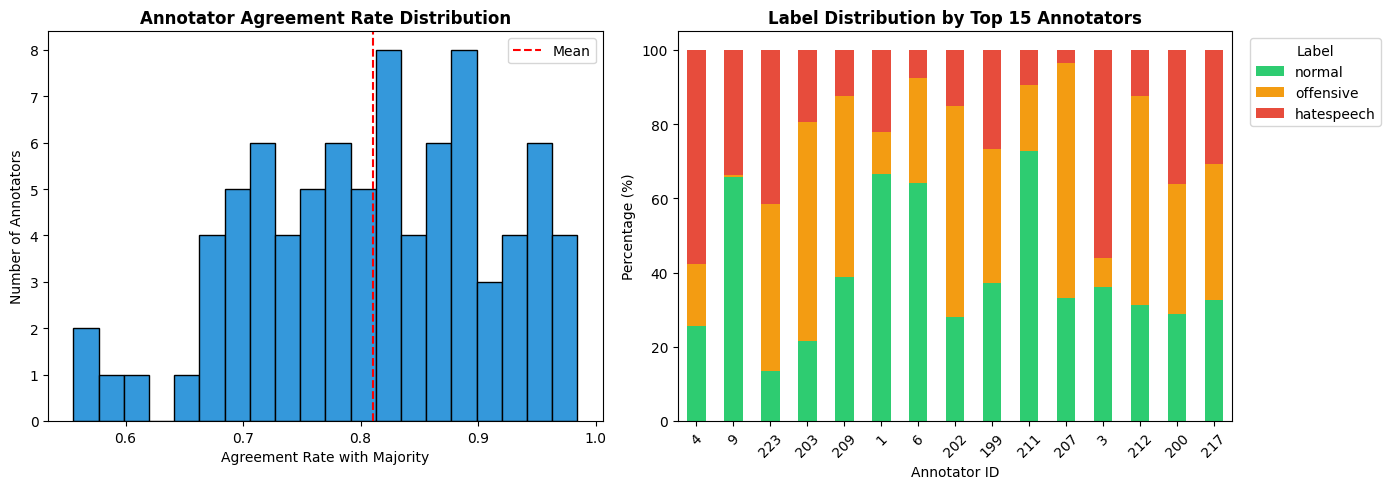

In [ ]:
# Visualize annotator behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Agreement rate distribution
axes[0].hist(experienced_annotators['agreement_rate'], bins=20, color='#3498db', edgecolor='black')
axes[0].axvline(experienced_annotators['agreement_rate'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('Annotator Agreement Rate Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Agreement Rate with Majority')
axes[0].set_ylabel('Number of Annotators')
axes[0].legend()

# Plot 2: Label distribution by annotator (top 15 by sample size)
top_annotators = experienced_annotators.nlargest(15, 'total_labels')
top_annotators[['normal', 'offensive', 'hatespeech']].plot(
    kind='bar', stacked=True, ax=axes[1],
    color=['#2ecc71', '#f39c12', '#e74c3c']
)
axes[1].set_title('Label Distribution by Top 15 Annotators', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Annotator ID')
axes[1].set_ylabel('Percentage (%)')
axes[1].legend(title='Label', bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

** Identify Annotator Bias (Strict vs Lenient)**

In [ ]:
# Calculate annotator bias (strict vs lenient)
# Bias score: high hatespeech% = strict, high normal% = lenient

experienced_annotators['strictness_score'] = (
    experienced_annotators['hatespeech'] - experienced_annotators['normal']
)

# Categorize annotators
def categorize_annotator(row):
    if row['strictness_score'] > 20:
        return 'Strict (harsh)'
    elif row['strictness_score'] < -20:
        return 'Lenient (soft)'
    else:
        return 'Balanced'

experienced_annotators['bias_category'] = experienced_annotators.apply(categorize_annotator, axis=1)

print("Annotator Bias Distribution:")
print(experienced_annotators['bias_category'].value_counts())

print("\n🔴 Top 5 STRICT Annotators (label hatespeech often):")
print(experienced_annotators.nlargest(5, 'strictness_score')[['total_labels', 'agreement_rate', 'normal', 'hatespeech', 'strictness_score']])

print("\n🟢 Top 5 LENIENT Annotators (label normal often):")
print(experienced_annotators.nsmallest(5, 'strictness_score')[['total_labels', 'agreement_rate', 'normal', 'hatespeech', 'strictness_score']])

Annotator Bias Distribution:
bias_category
Lenient (soft)    36
Balanced          32
Strict (harsh)    15
Name: count, dtype: int64

🔴 Top 5 STRICT Annotators (label hatespeech often):
              total_labels  agreement_rate     normal  hatespeech  \
annotator_id                                                        
23                     200        0.965000   1.000000   94.500000   
81                     166        0.957831   1.807229   93.373494   
68                     171        0.959064   7.017544   88.304094   
46                     746        0.950402  22.654155   72.117962   
20                     114        0.877193  23.684211   70.175439   

              strictness_score  
annotator_id                    
23                   93.500000  
81                   91.566265  
68                   81.286550  
46                   49.463807  
20                   46.491228  

🟢 Top 5 LENIENT Annotators (label normal often):
              total_labels  agreement_rate     nor

**Visualize Annotator Bias**

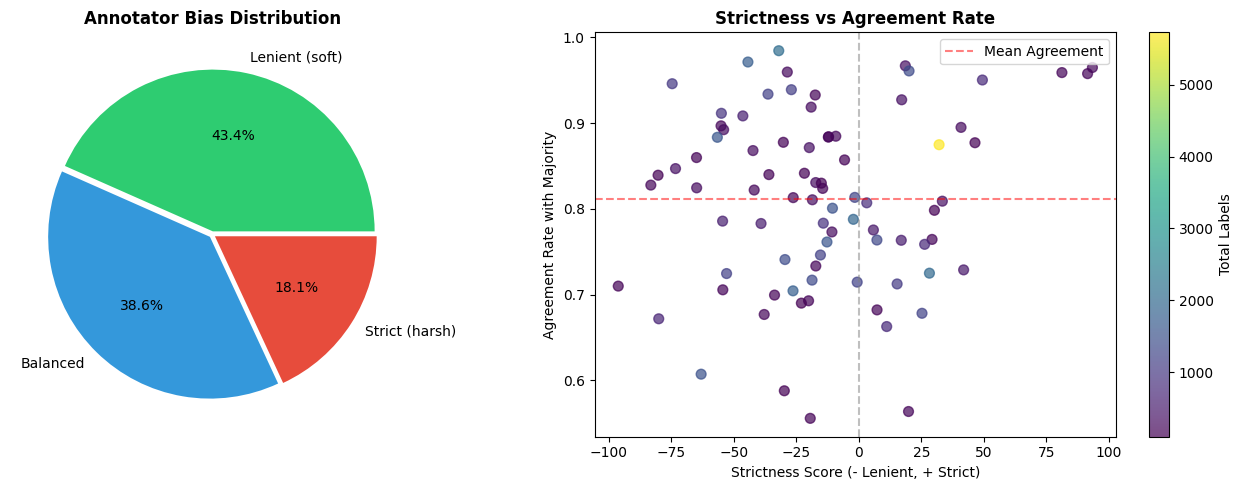

Ideal annotators: Near 0 strictness + High agreement rate


In [ ]:
# Visualize annotator bias
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bias category distribution
bias_counts = experienced_annotators['bias_category'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c']
axes[0].pie(bias_counts.values, labels=bias_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02, 0.02, 0.02])
axes[0].set_title('Annotator Bias Distribution', fontsize=12, fontweight='bold')

# Plot 2: Strictness score vs Agreement rate
scatter = axes[1].scatter(
    experienced_annotators['strictness_score'],
    experienced_annotators['agreement_rate'],
    c=experienced_annotators['total_labels'],
    cmap='viridis',
    alpha=0.7,
    s=50
)
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(experienced_annotators['agreement_rate'].mean(), color='red', linestyle='--', alpha=0.5, label='Mean Agreement')
axes[1].set_xlabel('Strictness Score (- Lenient, + Strict)')
axes[1].set_ylabel('Agreement Rate with Majority')
axes[1].set_title('Strictness vs Agreement Rate', fontsize=12, fontweight='bold')
axes[1].legend()
plt.colorbar(scatter, ax=axes[1], label='Total Labels')

plt.tight_layout()
plt.show()

print("Ideal annotators: Near 0 strictness + High agreement rate")

**Calculate Krippendorff's Alpha**

This is the key metric. I need to format the data as a reliability matrix where:
- Rows = annotators (3 per item)
- Columns = items (posts)
- Values = label codes (0=hatespeech, 1=normal, 2=offensive)

In [ ]:
# Calculate Krippendorff's Alpha (FAST version)
import krippendorff

# Create label mapping
label_to_num = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

# Build data in simpler format: list of lists
# Each inner list = labels from all annotators for one item
reliability_data = []

for post_id, sample in raw_data.items():
    item_labels = [label_to_num[ann['label']] for ann in sample['annotators']]
    reliability_data.append(item_labels)

# Convert to numpy array and transpose (annotators x items)
reliability_matrix = np.array(reliability_data).T

print(f" Reliability matrix shape: {reliability_matrix.shape}")
print(f"   - {reliability_matrix.shape[0]} annotators per item")
print(f"   - {reliability_matrix.shape[1]} items")

# Calculate Krippendorff's Alpha
alpha = krippendorff.alpha(reliability_matrix, level_of_measurement='nominal')

print(f"\n Krippendorff's Alpha: {alpha:.4f}")

# Interpretation
if alpha >= 0.8:
    interpretation = "✅ Reliable - Good for ML training"
elif alpha >= 0.667:
    interpretation = "⚠️ Acceptable - Use with caution"
else:
    interpretation = "❌ Poor - Guidelines need improvement"

print(f"📋 Interpretation: {interpretation}")

 Reliability matrix shape: (3, 20148)
   - 3 annotators per item
   - 20148 items

 Krippendorff's Alpha: 0.4597
📋 Interpretation: ❌ Poor - Guidelines need improvement


**Visualize Alpha on Quality Scale**

Showing where our alpha falls on the standard interpretation scale helps communicate findings to non-technical stakeholders.

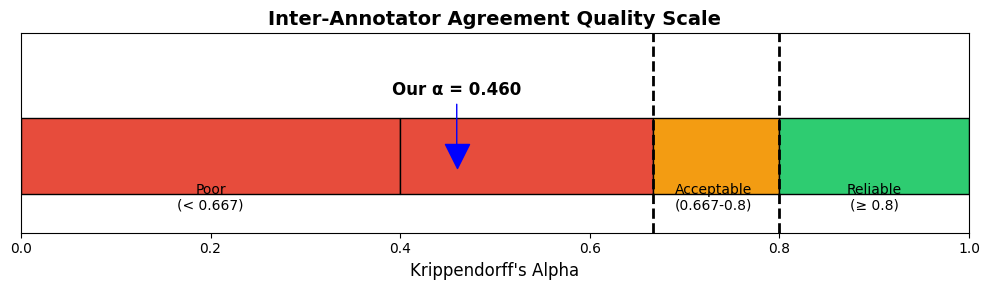

Our dataset needs significant guideline improvements before ML training


In [ ]:
# Visualize Krippendorff's Alpha in context
fig, ax = plt.subplots(figsize=(10, 3))

# Create scale
scale_colors = ['#e74c3c', '#e74c3c', '#f39c12', '#2ecc71']
scale_ranges = [0, 0.4, 0.667, 0.8, 1.0]
scale_labels = ['Poor', 'Poor', 'Acceptable', 'Reliable']

# Draw colored bars
for i in range(len(scale_ranges)-1):
    ax.barh(0, scale_ranges[i+1]-scale_ranges[i], left=scale_ranges[i],
            height=0.5, color=scale_colors[i], edgecolor='black')

# Add threshold lines
ax.axvline(0.667, color='black', linestyle='--', linewidth=2)
ax.axvline(0.8, color='black', linestyle='--', linewidth=2)

# Mark our Alpha value
ax.scatter([alpha], [0], s=300, color='blue', zorder=5, marker='v')
ax.annotate(f'Our α = {alpha:.3f}', xy=(alpha, 0), xytext=(alpha, 0.4),
            fontsize=12, fontweight='bold', ha='center',
            arrowprops=dict(arrowstyle='->', color='blue'))

# Labels
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.8)
ax.set_xlabel("Krippendorff's Alpha", fontsize=12)
ax.set_yticks([])
ax.set_title("Inter-Annotator Agreement Quality Scale", fontsize=14, fontweight='bold')

# Add text labels
ax.text(0.2, -0.35, 'Poor\n(< 0.667)', ha='center', fontsize=10)
ax.text(0.73, -0.35, 'Acceptable\n(0.667-0.8)', ha='center', fontsize=10)
ax.text(0.9, -0.35, 'Reliable\n(≥ 0.8)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Our dataset needs significant guideline improvements before ML training")

**Analyze Rationales**

In [ ]:
# Explore rationales in the dataset
samples_with_rationales = 0
samples_without_rationales = 0

for post_id, sample in raw_data.items():
    if sample['rationales'] and len(sample['rationales']) > 0:
        # Check if rationales have any marked tokens
        has_marked = any(1 in r for r in sample['rationales'])
        if has_marked:
            samples_with_rationales += 1
        else:
            samples_without_rationales += 1
    else:
        samples_without_rationales += 1

print("Rationales Availability:")
print(f"   With rationales: {samples_with_rationales:,} ({samples_with_rationales/len(raw_data)*100:.1f}%)")
print(f"   Without rationales: {samples_without_rationales:,} ({samples_without_rationales/len(raw_data)*100:.1f}%)")

Rationales Availability:
   With rationales: 11,413 (56.6%)
   Without rationales: 8,735 (43.4%)


**Example with rationales**

In [ ]:
# View example with rationales
def show_sample_with_rationale(post_id):
    sample = raw_data[post_id]
    tokens = sample['post_tokens']
    text = " ".join(tokens)

    print(f" Post ID: {post_id}")
    print(f" Text: {text}")
    print(f"\n Annotator Labels:")

    for ann in sample['annotators']:
        print(f"   Annotator {ann['annotator_id']}: {ann['label']} (target: {ann['target']})")

    print(f"\n Rationales (highlighted words):")
    if sample['rationales']:
        for i, rationale in enumerate(sample['rationales']):
            if rationale:
                highlighted = [tokens[j] for j, val in enumerate(rationale) if val == 1]
                if highlighted:
                    print(f"   Annotator {i+1}: {highlighted}")
                else:
                    print(f"   Annotator {i+1}: (no words highlighted)")

# Find a sample with disagreement AND rationales
for post_id, sample in raw_data.items():
    labels = [ann['label'] for ann in sample['annotators']]
    if len(set(labels)) > 1 and sample['rationales']:  # Has disagreement
        has_rationale = any(1 in r for r in sample['rationales'] if r)
        if has_rationale:
            show_sample_with_rationale(post_id)
            break

 Post ID: 1179088797964763136_twitter
 Text: <user> i am bit confused coz chinese ppl can not access twitter thn how this ching chong using it i think he pakistani 🤔 🤔 🤔

 Annotator Labels:
   Annotator 1: hatespeech (target: ['Asian'])
   Annotator 4: offensive (target: ['Asian'])
   Annotator 3: hatespeech (target: ['Asian'])

 Rationales (highlighted words):
   Annotator 1: ['ching', 'chong']
   Annotator 2: ['ching', 'chong']
   Annotator 3: ['ching', 'chong']


**Analyze disagreement samples with rationales**

In [ ]:
# Collect disagreement samples for RCA
disagreement_samples = []

for post_id, sample in raw_data.items():
    labels = [ann['label'] for ann in sample['annotators']]

    # Only samples with disagreement
    if len(set(labels)) > 1:
        tokens = sample['post_tokens']
        text = " ".join(tokens)

        # Get highlighted words from rationales (with safety check)
        highlighted_words = []
        if sample['rationales']:
            for rationale in sample['rationales']:
                if rationale and len(rationale) == len(tokens):  # Safety check
                    words = [tokens[j] for j, val in enumerate(rationale) if val == 1]
                    highlighted_words.extend(words)

        disagreement_samples.append({
            'post_id': post_id,
            'text': text,
            'labels': labels,
            'label_set': tuple(sorted(set(labels))),
            'targets': [ann['target'] for ann in sample['annotators']],
            'highlighted_words': list(set(highlighted_words)),
            'text_length': len(tokens)
        })

df_disagreement = pd.DataFrame(disagreement_samples)

print(f" Total disagreement samples: {len(df_disagreement):,}")
print(f"\n Disagreement patterns:")
print(df_disagreement['label_set'].value_counts())

 Total disagreement samples: 10,303

 Disagreement patterns:
label_set
(normal, offensive)                4088
(hatespeech, offensive)            3916
(hatespeech, normal)               1380
(hatespeech, normal, offensive)     919
Name: count, dtype: int64


**Collect Problematic Words from Rationales**

The rationales field shows which words each annotator highlighted as problematic. By collecting these from disagreement cases, I can identify patterns in what causes confusion.

In [ ]:
# Analyze common problematic words
from collections import Counter

# Collect all highlighted words from disagreement samples
all_highlighted = []
for words in df_disagreement['highlighted_words']:
    all_highlighted.extend([w.lower() for w in words])

# Count frequency
word_counts = Counter(all_highlighted)

print(" Top 30 Most Highlighted Words in Disagreement Cases:")
print("=" * 50)
for word, count in word_counts.most_common(30):
    print(f"   {word:<20} {count:>5}")

 Top 30 Most Highlighted Words in Disagreement Cases:
   the                   1437
   and                   1075
   a                     1050
   to                     976
   of                     792
   are                    746
   nigger                 690
   white                  664
   in                     603
   is                     592
   you                    569
   not                    521
   that                   484
   they                   437
   jews                   420
   retarded               409
   i                      407
   ghetto                 404
   it                     386
   for                    379
   bitch                  344
   with                   326
   have                   305
   be                     304
   muslim                 302
   women                  301
   all                    285
   niggers                284
   kike                   280
   on                     275


**Analyze words by disagreement type**

In [ ]:
# Compare highlighted words by disagreement type
def get_top_words(label_set, n=10):
    subset = df_disagreement[df_disagreement['label_set'] == label_set]
    words = []
    for w_list in subset['highlighted_words']:
        words.extend([w.lower() for w in w_list])
    return Counter(words).most_common(n)

print(" Top Words by Disagreement Type:\n")

print("1️⃣ Normal vs Offensive:")
for word, count in get_top_words(('normal', 'offensive')):
    print(f"   {word}: {count}")

print("\n2️⃣ Hatespeech vs Offensive:")
for word, count in get_top_words(('hatespeech', 'offensive')):
    print(f"   {word}: {count}")

print("\n3️⃣ Hatespeech vs Normal:")
for word, count in get_top_words(('hatespeech', 'normal')):
    print(f"   {word}: {count}")

 Top Words by Disagreement Type:

1️⃣ Normal vs Offensive:
   the: 416
   a: 299
   and: 271
   to: 271
   of: 226
   are: 212
   white: 211
   is: 207
   in: 205
   ghetto: 204

2️⃣ Hatespeech vs Offensive:
   the: 892
   and: 705
   a: 649
   to: 605
   nigger: 560
   of: 499
   are: 473
   white: 382
   you: 356
   in: 335

3️⃣ Hatespeech vs Normal:
   the: 129
   nigger: 120
   a: 102
   to: 100
   and: 99
   white: 71
   of: 67
   moslem: 66
   in: 63
   are: 61


**Filter Stop Words & Get Real Insights**

In [ ]:
# Filter stop words using NLTK
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Get English stop words from NLTK (179 words)
stop_words = set(stopwords.words('english'))

print(f" NLTK Stop Words: {len(stop_words)} words")
print(f"   Examples: {list(stop_words)[:10]}")

# Filter and recount
filtered_words = [w for w in all_highlighted if w not in stop_words]
filtered_counts = Counter(filtered_words)

print(f"\n Top 30 Problematic Words (Stop Words Removed):")
print("=" * 50)
for word, count in filtered_counts.most_common(30):
    print(f"   {word:<20} {count:>5}")

 NLTK Stop Words: 198 words
   Examples: ['his', 'the', 'shan', 'needn', 'myself', 'its', 'on', "they'd", 'same', 'you']

 Top 30 Problematic Words (Stop Words Removed):
   nigger                 690
   white                  664
   jews                   420
   retarded               409
   ghetto                 404
   bitch                  344
   muslim                 302
   women                  301
   niggers                284
   kike                   280
   faggot                 271
   fucking                261
   like                   251
   <number>               247
   people                 235
   gay                    205
   fuck                   194
   moslem                 187
   black                  179
   hate                   175
   raped                  175
   shit                   174
   faggots                169
   sand                   166
   immigrants             164
   muslims                158
   illegal                153
   blacks           

## Step 9: Root Cause Analysis

**Why do RCA?**
Knowing THAT annotators disagree isn't enough. I need to know WHY.

**My approach:**
1. Collect all highlighted words from disagreement samples
2. Remove stop words (the, and, a, etc.)
3. Categorize remaining words into RCA buckets

**Categories I defined:**
- Racial Slurs: explicit racial slurs
- Religious Terms: references to religious groups
- Gender/Sexuality: terms related to gender or orientation
- Disability Slurs: terms mocking disabilities
- Group References: neutral group mentions (white, black, immigrants)
- Profanity: general swear words
- Dehumanizing: language treating people as less than human

**Why these categories?**
Based on common patterns in hate speech literature and what I observed in the data. This isn't a perfect taxonomy - in a real project, I'd iterate based on team feedback.

**Key finding:**
Group References (20.5%) cause the most disagreement because words like "white" or "black" aren't inherently hateful - context determines meaning.

In [ ]:
# Categorize problematic words for RCA taxonomy
rca_categories = {
    'Racial Slurs': ['nigger', 'niggers', 'nigga', 'chink', 'kike', 'spic', 'coon', 'gook'],
    'Religious Terms': ['jews', 'jewish', 'muslim', 'muslims', 'islam', 'moslem', 'christian'],
    'Gender/Sexuality': ['women', 'woman', 'bitch', 'gay', 'fag', 'faggot', 'faggots', 'lesbian', 'trans', 'dyke'],
    'Disability Slurs': ['retarded', 'retard', 'autistic', 'crazy', 'insane'],
    'Group References': ['white', 'black', 'blacks', 'people', 'men', 'immigrants', 'illegal'],
    'Profanity': ['fuck', 'fucking', 'shit', 'ass', 'damn', 'hell', 'hate'],
    'Dehumanizing': ['trash', 'garbage', 'animal', 'animals', 'vermin', 'ghetto', 'raped']
}

print(" RCA Category Analysis:")
print("=" * 60)

category_counts = {}
for category, keywords in rca_categories.items():
    count = sum(filtered_counts.get(word, 0) for word in keywords)
    category_counts[category] = count

    # Only show categories with matches
    matched_words = [(word, filtered_counts.get(word, 0)) for word in keywords if filtered_counts.get(word, 0) > 0]
    if matched_words:
        print(f"\n  {category}: (Total: {count})")
        for word, word_count in sorted(matched_words, key=lambda x: -x[1]):
            print(f"      {word}: {word_count}")

# Visualize
print("\n" + "=" * 60)
print(" Category Summary:")
for cat, count in sorted(category_counts.items(), key=lambda x: -x[1]):
    bar = "█" * (count // 50)
    print(f"   {cat:<20} {count:>5} {bar}")

 RCA Category Analysis:

  Racial Slurs: (Total: 1430)
      nigger: 690
      niggers: 284
      kike: 280
      nigga: 68
      spic: 47
      gook: 23
      chink: 19
      coon: 19

  Religious Terms: (Total: 1286)
      jews: 420
      muslim: 302
      moslem: 187
      muslims: 158
      islam: 140
      jewish: 49
      christian: 30

  Gender/Sexuality: (Total: 1469)
      bitch: 344
      women: 301
      faggot: 271
      gay: 205
      faggots: 169
      dyke: 64
      woman: 58
      fag: 26
      lesbian: 23
      trans: 8

  Disability Slurs: (Total: 568)
      retarded: 409
      retard: 133
      crazy: 13
      insane: 7
      autistic: 6

  Group References: (Total: 1658)
      white: 664
      people: 235
      black: 179
      immigrants: 164
      illegal: 153
      blacks: 152
      men: 111

  Profanity: (Total: 982)
      fucking: 261
      fuck: 194
      hate: 175
      shit: 174
      ass: 134
      hell: 31
      damn: 13

  Dehumanizing: (Total: 700)
     

**Visualize RCA Categories**

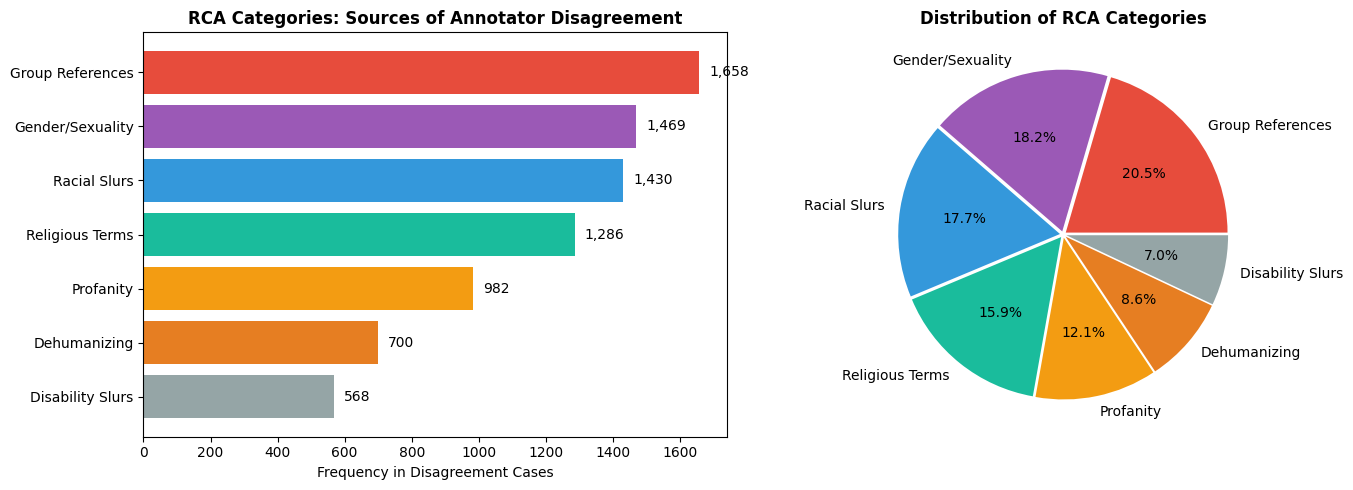

Insight: Group References & Gender/Sexuality cause most disagreement due to context dependency


In [ ]:
# Visualize RCA categories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort categories by count
sorted_categories = sorted(category_counts.items(), key=lambda x: -x[1])
categories = [c[0] for c in sorted_categories]
counts = [c[1] for c in sorted_categories]

# Plot 1: Bar chart
colors = ['#e74c3c', '#9b59b6', '#3498db', '#1abc9c', '#f39c12', '#e67e22', '#95a5a6']
bars = axes[0].barh(categories[::-1], counts[::-1], color=colors[::-1])
axes[0].set_xlabel('Frequency in Disagreement Cases')
axes[0].set_title('RCA Categories: Sources of Annotator Disagreement', fontsize=12, fontweight='bold')

# Add count labels
for bar, count in zip(bars, counts[::-1]):
    axes[0].text(count + 30, bar.get_y() + bar.get_height()/2, f'{count:,}', va='center', fontsize=10)

# Plot 2: Pie chart
axes[1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, explode=[0.02]*len(counts))
axes[1].set_title('Distribution of RCA Categories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Insight: Group References & Gender/Sexuality cause most disagreement due to context dependency")

## Step 10: Prepare Data for Dashboard

**Why export to CSV?**
The analysis in this notebook is complete, but I want to:
1. Share findings with non-technical stakeholders via interactive dashboard
2. Enable ongoing monitoring of annotation quality
3. Create a reusable pipeline

**Files I'll create:**
- `posts_analysis.csv`: All posts with agreement info and RCA categories
- `annotators_analysis.csv`: Individual annotator statistics  
- `summary_metrics.csv`: KPIs for dashboard overview
- `disagreement_samples.csv`: Only disagreement cases for review queue

**Build unified post-level schema**

In [ ]:
# Build unified post-level schema
posts_data = []

for post_id, sample in raw_data.items():
    tokens = sample['post_tokens']
    text = " ".join(tokens)
    labels = [ann['label'] for ann in sample['annotators']]
    targets = [t for ann in sample['annotators'] for t in ann['target']]

    # Agreement info
    unique_labels = len(set(labels))
    majority_label = Counter(labels).most_common(1)[0][0]

    if unique_labels == 1:
        agreement_type = "Full"
    elif unique_labels == 2:
        agreement_type = "Partial"
    else:
        agreement_type = "None"

    # Get highlighted words
    highlighted_words = []
    if sample['rationales']:
        for rationale in sample['rationales']:
            if rationale and len(rationale) == len(tokens):
                words = [tokens[j].lower() for j, val in enumerate(rationale) if val == 1]
                highlighted_words.extend(words)
    highlighted_words = list(set(highlighted_words))

    # Assign RCA category based on highlighted words
    def assign_rca(words):
        rca_map = {
            'Racial Slurs': ['nigger', 'niggers', 'nigga', 'chink', 'kike', 'spic', 'coon', 'gook'],
            'Religious Terms': ['jews', 'jewish', 'muslim', 'muslims', 'islam', 'moslem'],
            'Gender/Sexuality': ['women', 'woman', 'bitch', 'gay', 'fag', 'faggot', 'faggots', 'dyke'],
            'Disability Slurs': ['retarded', 'retard', 'autistic'],
            'Group References': ['white', 'black', 'blacks', 'immigrants', 'illegal'],
            'Profanity': ['fuck', 'fucking', 'shit', 'ass', 'hate'],
            'Dehumanizing': ['ghetto', 'trash', 'garbage', 'animal', 'animals']
        }
        for category, keywords in rca_map.items():
            if any(w in keywords for w in words):
                return category
        return 'Other/Unclear'

    rca_category = assign_rca(highlighted_words)

    posts_data.append({
        'post_id': post_id,
        'text': text,
        'text_length': len(tokens),
        'label_1': labels[0],
        'label_2': labels[1],
        'label_3': labels[2],
        'majority_label': majority_label,
        'agreement_type': agreement_type,
        'unique_labels': unique_labels,
        'has_disagreement': unique_labels > 1,
        'target_groups': ','.join(set(targets)) if targets else 'None',
        'highlighted_words': ','.join(highlighted_words) if highlighted_words else '',
        'rca_category': rca_category if unique_labels > 1 else 'N/A'
    })

df_posts = pd.DataFrame(posts_data)

print(f" Posts dataset created: {len(df_posts):,} rows")
print(f"\n Schema:")
print(df_posts.dtypes)
print(f"\n Sample rows:")
df_posts.head(3)

 Posts dataset created: 20,148 rows

 Schema:
post_id              object
text                 object
text_length           int64
label_1              object
label_2              object
label_3              object
majority_label       object
agreement_type       object
unique_labels         int64
has_disagreement       bool
target_groups        object
highlighted_words    object
rca_category         object
dtype: object

 Sample rows:


,post_id,text,text_length,label_1,label_2,label_3,majority_label,agreement_type,unique_labels,has_disagreement,target_groups,highlighted_words,rca_category
0,1179055004553900032_twitter,i dont think im getting my baby them white 9 he has two white j and nikes not even touched,20,normal,normal,normal,normal,Full,1,False,None,,N/A
1,1179063826874032128_twitter,we cannot continue calling ourselves feminists if the rights of all womxn arent addressed yes to...,42,normal,normal,normal,normal,Full,1,False,None,,N/A
2,1178793830532956161_twitter,nawt yall niggers ignoring me,5,normal,normal,hatespeech,normal,Partial,2,True,"None,African",,Other/Unclear


**Create annotator-level dataset**

In [ ]:
# Build annotator-level schema (using experienced_annotators)
df_annotator_export = experienced_annotators.copy()
df_annotator_export = df_annotator_export.reset_index()

# Rename columns for clarity
df_annotator_export.columns = [
    'annotator_id', 'total_labels', 'agreement_rate',
    'hatespeech_pct', 'normal_pct', 'offensive_pct',
    'strictness_score', 'bias_category'
]

# Round percentages
df_annotator_export['agreement_rate'] = df_annotator_export['agreement_rate'].round(3)
df_annotator_export['hatespeech_pct'] = df_annotator_export['hatespeech_pct'].round(1)
df_annotator_export['normal_pct'] = df_annotator_export['normal_pct'].round(1)
df_annotator_export['offensive_pct'] = df_annotator_export['offensive_pct'].round(1)
df_annotator_export['strictness_score'] = df_annotator_export['strictness_score'].round(1)

print(f" Annotator dataset created: {len(df_annotator_export)} rows")
print(f"\n Schema:")
print(df_annotator_export.dtypes)
print(f"\n Sample rows:")
df_annotator_export.head()

 Annotator dataset created: 83 rows

 Schema:
annotator_id          int64
total_labels          int64
agreement_rate      float64
hatespeech_pct      float64
normal_pct          float64
offensive_pct       float64
strictness_score    float64
bias_category        object
dtype: object

 Sample rows:


,annotator_id,total_labels,agreement_rate,hatespeech_pct,normal_pct,offensive_pct,strictness_score,bias_category
0,9,2075,0.985,33.7,65.7,0.6,-32.0,Lenient (soft)
1,1,1748,0.971,22.1,66.5,11.4,-44.4,Lenient (soft)
2,96,333,0.967,55.9,37.2,6.9,18.6,Balanced
3,23,200,0.965,94.5,1.0,4.5,93.5,Strict (harsh)
4,3,1358,0.961,56.1,36.0,7.9,20.1,Strict (harsh)


**Create summary metrics dataset**

In [ ]:
# Build summary metrics for dashboard KPIs
summary_data = {
    'metric': [
        'total_posts',
        'total_annotators',
        'total_annotations',
        'krippendorff_alpha',
        'full_agreement_rate',
        'partial_agreement_rate',
        'no_agreement_rate',
        'majority_normal_pct',
        'majority_offensive_pct',
        'majority_hatespeech_pct',
        'annotator_mean_agreement',
        'strict_annotators_pct',
        'lenient_annotators_pct',
        'balanced_annotators_pct',
        'top_rca_category',
        'samples_with_rationales_pct'
    ],
    'value': [
        len(df_posts),
        df_annotators['annotator_id'].nunique(),
        len(df_annotators),
        round(alpha, 4),
        round(len(df_posts[df_posts['agreement_type'] == 'Full']) / len(df_posts) * 100, 1),
        round(len(df_posts[df_posts['agreement_type'] == 'Partial']) / len(df_posts) * 100, 1),
        round(len(df_posts[df_posts['agreement_type'] == 'None']) / len(df_posts) * 100, 1),
        round(len(df_posts[df_posts['majority_label'] == 'normal']) / len(df_posts) * 100, 1),
        round(len(df_posts[df_posts['majority_label'] == 'offensive']) / len(df_posts) * 100, 1),
        round(len(df_posts[df_posts['majority_label'] == 'hatespeech']) / len(df_posts) * 100, 1),
        round(experienced_annotators['agreement_rate'].mean() * 100, 1),
        round(len(experienced_annotators[experienced_annotators['bias_category'] == 'Strict (harsh)']) / len(experienced_annotators) * 100, 1),
        round(len(experienced_annotators[experienced_annotators['bias_category'] == 'Lenient (soft)']) / len(experienced_annotators) * 100, 1),
        round(len(experienced_annotators[experienced_annotators['bias_category'] == 'Balanced']) / len(experienced_annotators) * 100, 1),
        'Group References',
        round(samples_with_rationales / len(raw_data) * 100, 1)
    ]
}

df_summary = pd.DataFrame(summary_data)

print(f" Summary metrics created: {len(df_summary)} KPIs")
print(f"\n All Metrics:")
print(df_summary.to_string(index=False))

 Summary metrics created: 16 KPIs

 All Metrics:
                     metric            value
                total_posts            20148
           total_annotators              253
          total_annotations            60444
         krippendorff_alpha           0.4597
        full_agreement_rate             48.9
     partial_agreement_rate             46.6
          no_agreement_rate              4.6
        majority_normal_pct             40.5
     majority_offensive_pct             28.6
    majority_hatespeech_pct             30.9
   annotator_mean_agreement             81.1
      strict_annotators_pct             18.1
     lenient_annotators_pct             43.4
    balanced_annotators_pct             38.6
           top_rca_category Group References
samples_with_rationales_pct             56.6


**Export all datasets to CSV**

In [ ]:
# Export all datasets to CSV
import os

# Create output folder
output_folder = 'hatexplain_analysis_output'
os.makedirs(output_folder, exist_ok=True)

# Export CSVs
df_posts.to_csv(f'{output_folder}/posts_analysis.csv', index=False)
df_annotator_export.to_csv(f'{output_folder}/annotators_analysis.csv', index=False)
df_summary.to_csv(f'{output_folder}/summary_metrics.csv', index=False)

# Also export disagreement samples for RCA review
df_disagreement_export = df_posts[df_posts['has_disagreement'] == True].copy()
df_disagreement_export.to_csv(f'{output_folder}/disagreement_samples.csv', index=False)

print(" All datasets exported!")
print(f"\n Output folder: {output_folder}/")
print(f"\n Files created:")
print(f"   1. posts_analysis.csv         ({len(df_posts):,} rows)")
print(f"   2. annotators_analysis.csv    ({len(df_annotator_export):,} rows)")
print(f"   3. summary_metrics.csv        ({len(df_summary):,} rows)")
print(f"   4. disagreement_samples.csv   ({len(df_disagreement_export):,} rows)")

# Show file sizes
for filename in os.listdir(output_folder):
    filepath = os.path.join(output_folder, filename)
    size_kb = os.path.getsize(filepath) / 1024
    print(f"\n    {filename}: {size_kb:.1f} KB")

 All datasets exported!

 Output folder: hatexplain_analysis_output/

 Files created:
   1. posts_analysis.csv         (20,148 rows)
   2. annotators_analysis.csv    (83 rows)
   3. summary_metrics.csv        (16 rows)
   4. disagreement_samples.csv   (10,303 rows)

    disagreement_samples.csv: 2760.0 KB

    annotators_analysis.csv: 3.9 KB

    posts_analysis.csv: 5018.1 KB

    summary_metrics.csv: 0.4 KB


**Download files**

In [ ]:
# Download files to your computer
from google.colab import files

print(" Downloading files...")
print("   (Browser will prompt to save each file)\n")

for filename in os.listdir(output_folder):
    filepath = os.path.join(output_folder, filename)
    files.download(filepath)
    print(f" Downloaded: {filename}")

   (Browser will prompt to save each file)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: disagreement_samples.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: annotators_analysis.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: posts_analysis.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: summary_metrics.csv
